In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append(r'..\src')
from sklearn.manifold import TSNE
import forgi.visual.mplotlib as fvm
from forgi.graph.bulge_graph import BulgeGraph
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from GMfold import gmfold, gm_dot_bracket
import ast
from scipy.spatial.distance import cdist
import matplotlib.patches as mpatches
import string

In [2]:
df = pd.read_csv(r'../data/fold_published.csv')
print(df['Sequence'].apply(len).max())
df['faces'] = df['faces'].apply(ast.literal_eval)
df['energy_faces'] = df['energy_faces'].apply(ast.literal_eval)
df['Sequence'].drop_duplicates()
print('Numeber of unique sequences after preprocessing removing percentile:',len(df))


83
Numeber of unique sequences after preprocessing removing percentile: 4450


In [3]:
#Function to compute Motzkin path descriptors
def compute_descriptor_motzkin(input_string):
    descriptor = []
    sum = 0
    for count, char in enumerate(input_string):
        if char == '(':
            sum +=1
            descriptor.append(sum)
        elif char == ')':
            sum -=1 
            descriptor.append(sum)
        elif char == '.':
            descriptor.append(sum)      
    return descriptor  

# Descritpors Motzkin Path: Generate Fig. 6 of the paper.

In [4]:
# Compute Motzkin path descriptors
df['Descriptor'] = df['d_b'].apply(lambda x: compute_descriptor_motzkin(x) )
# Determine the maximum length of the lists
max_length = df['Descriptor'].apply(len).max()

# Store computed Motzkin path descriptors into a numpy array with padding
X_raw = np.zeros((len(df), max_length), dtype=int)
for i, row in enumerate(df['Descriptor']):
    X_raw[i,:len(row)] = row
 
#Remove entries that are identical for all datapoints
selector = VarianceThreshold(0)
X = selector.fit_transform(X_raw) 

print('The shape of the data matrix is:',X.shape)
# Run TSNE algorithm for dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=100).fit_transform(X)

The shape of the data matrix is: (4450, 78)


(-51.62732906341553, 36.69296855926514, -40.503474426269534, 41.69002075195313)

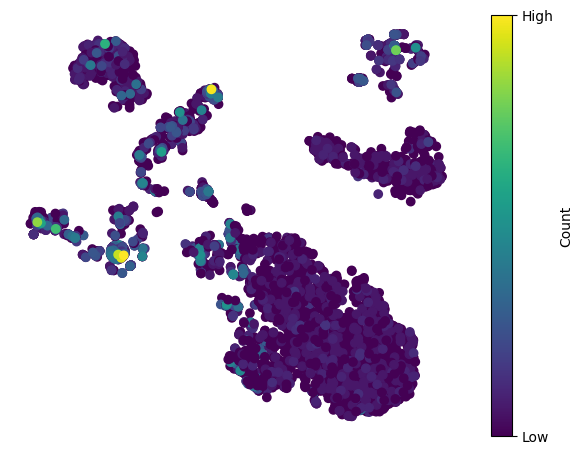

In [5]:
# Fig. 6 
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')
cbar = plt.colorbar(label='Count')
ticks = [colors.min(), colors.max()]
cbar.set_ticks(ticks)
cbar.set_ticklabels(['Low', 'High'])
plt.tight_layout()
plt.axis('off')

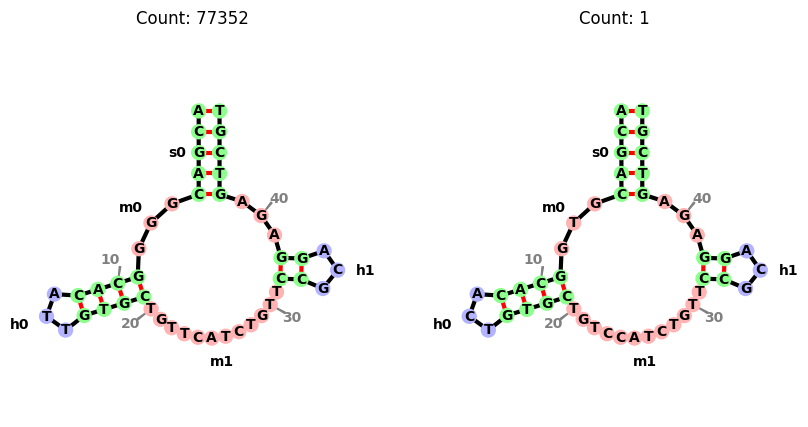

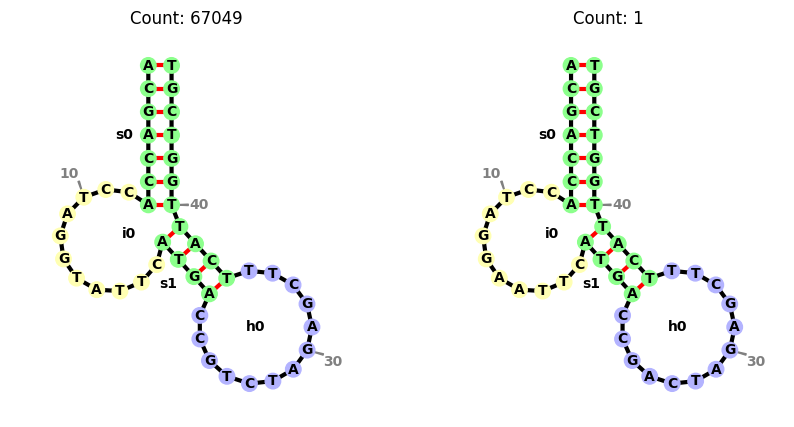

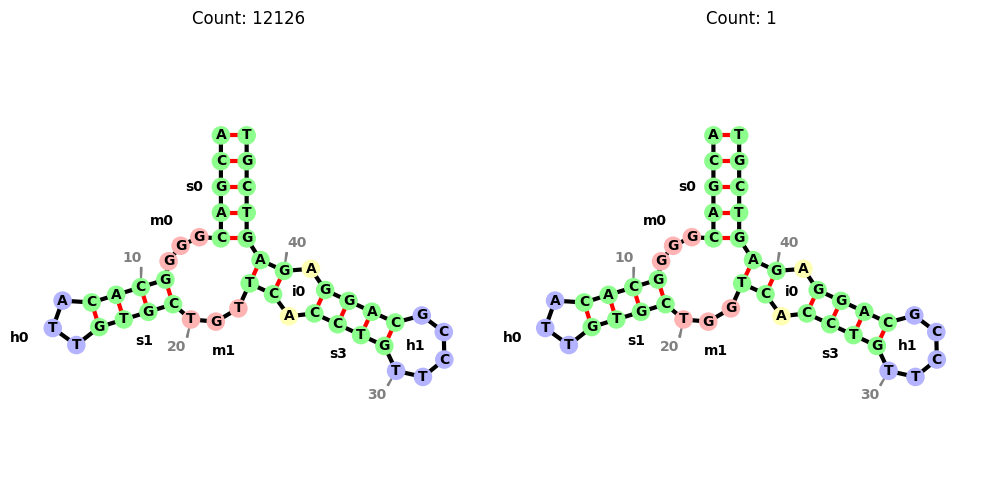

In [6]:
# DNA sequences represented in Fig. 3

index_x1 =[0,4327]
index_x2=[1, 4273 ]
index_x3 =[2,4291 ]
for lista in [index_x1, index_x2, index_x3]:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        seq = df['Sequence'][lista[0]]
        structs = gmfold(seq, l_fix = 4)
        d_b = gm_dot_bracket( seq, structs)
        bg = BulgeGraph.from_dotbracket( d_b  ,  seq)
        fvm.plot_rna(bg,ax = ax1, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
        ax1.set_title(f'Count: {df['Count'][lista[0]]}')
        seq = df['Sequence'][lista[1]]
        structs = gmfold(seq, l_fix = 4)
        d_b = gm_dot_bracket( seq, structs)
        bg = BulgeGraph.from_dotbracket( d_b  ,  seq)
        fvm.plot_rna(bg,ax = ax2, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
        ax2.set_title(f'Count: {df['Count'][lista[1]]}')
        
plt.tight_layout()
plt.axis('off')
plt.show()

In [7]:
# Consider all elements that have same Motzkin path descriptor as x_1, x_2 and x_3, which are the first, second, and fourth highest-count sequences. 
# In our dataset, the third-highest count sequence has secondary structure with the same topology as the first-highest count sequence
# To perform our analysis on a diverse set of topological structures, we select the fourth-highest-count sequence, 
# which has a secondary structure with a different topology from the first and second highest-count sequences. In the matrix X data points are not
# We refer to  the three sequences we analyze as x_1 with count 77352, x_2 with count 67049 and  x_3 with count 12126
l = 78
distances0 = cdist(X[0].reshape(1,l), X[:], 'euclidean')
distances1 = cdist(X[1].reshape(1,l), X[:], 'euclidean')
distances2 = cdist(X[2].reshape(1,l), X[:], 'euclidean')
zero_indices0 = np.where(distances0  == 0)[1]
zero_indices1 = np.where(distances1  == 0)[1]
zero_indices2 = np.where(distances2  == 0)[1]


# Descriptors Bag of Faces (BoF): Generate Fig. 7 of the paper.
Use BoF descriptors  to identify different energetic profiles associated with sequences with secondary structure with the same topology as that of x_1, x_2 and x_3

In [8]:

df0 = df.loc[zero_indices0]
df0 = df0.reset_index(drop= True)
df0 = df0.sort_values(by='Count', ascending=False)

df1 = df.loc[zero_indices1]
df1 = df1.reset_index(drop= True)
df1 = df1.sort_values(by='Count', ascending=False)

df2 = df.loc[zero_indices2]
df2 = df2.reset_index(drop= True)
df2 = df2.sort_values(by='Count', ascending=False)

In [9]:


def get_part_before_colon(input_string):
    if ':' in input_string:
        return input_string.split(':')[0]
    else:
        return input_string
# Function to generate BoF descriptors
def BoF_in_df(df):    
    words = []
    for i in range(len(df)):
        for j in range(len(df['faces'][i])):
            word_pair = (get_part_before_colon(df['faces'][i][j]), df['energy_faces'][i][j])
            if word_pair not in words:
                words.append(word_pair)
    vecotr_list = []
    for i in range(len(df)):
        binary_array = np.zeros(len(words), dtype=int)
        for j in range(len(df['faces'][i])):
            binary_array[words.index((get_part_before_colon(df['faces'][i][j]), df['energy_faces'][i][j]))] += 1
        vecotr_list.append(binary_array)
    # Apply function to each row
    df['binary_array'] = vecotr_list
    X_raw = np.zeros((len(df), len(words)), dtype=int)
    for count, desc in enumerate(df['binary_array']):
        X_raw[count, :] = desc
    
    return X_raw, words
# Generate BoF descriptors for each set of sequences sharing the  topology of the secondary structure
X_raw0, words0 = BoF_in_df(df0)
X_raw1, words1 = BoF_in_df(df1)
X_raw2, words2 = BoF_in_df(df2)

x_1


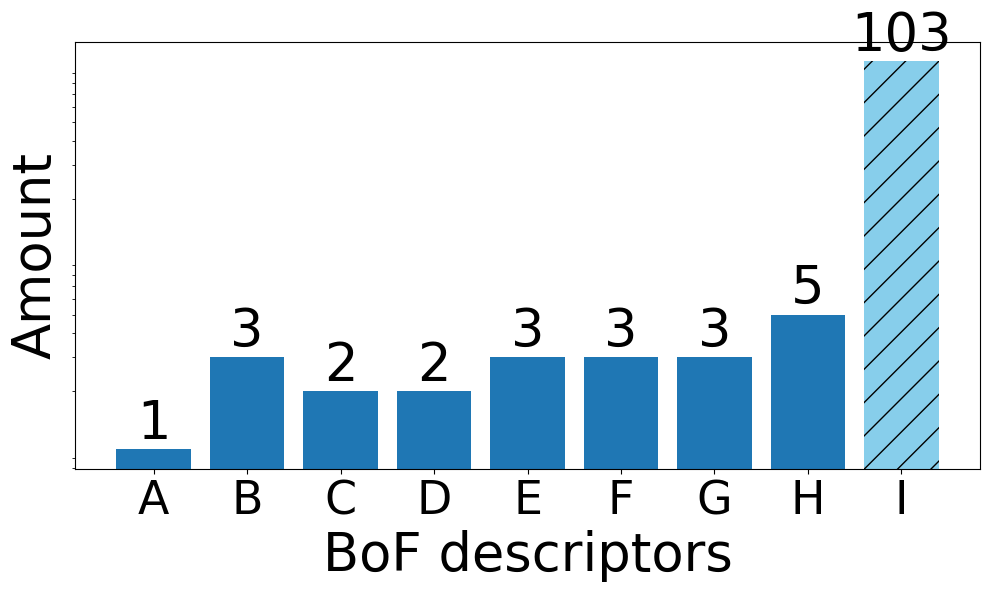

x_2


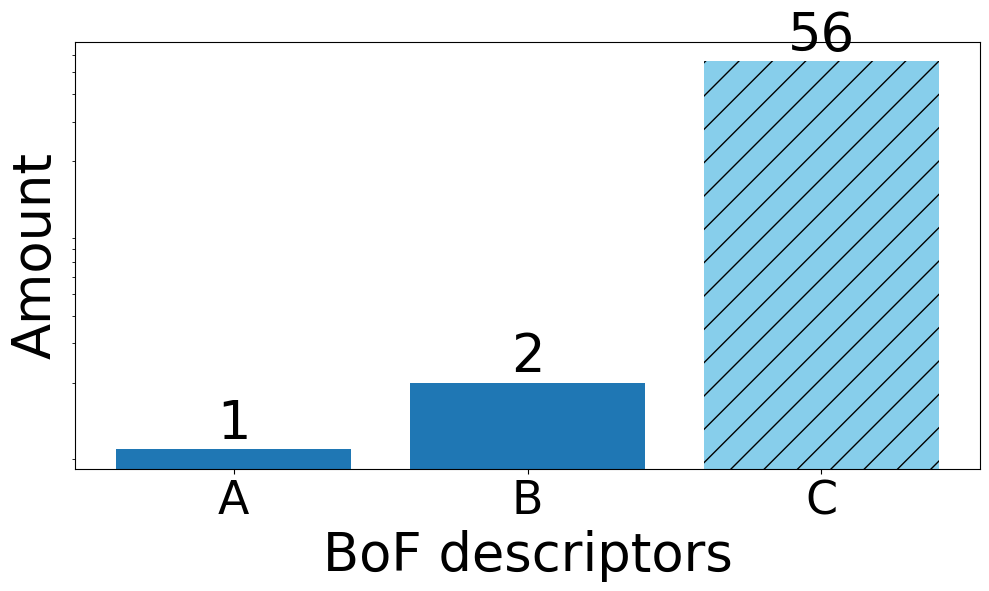

x_3


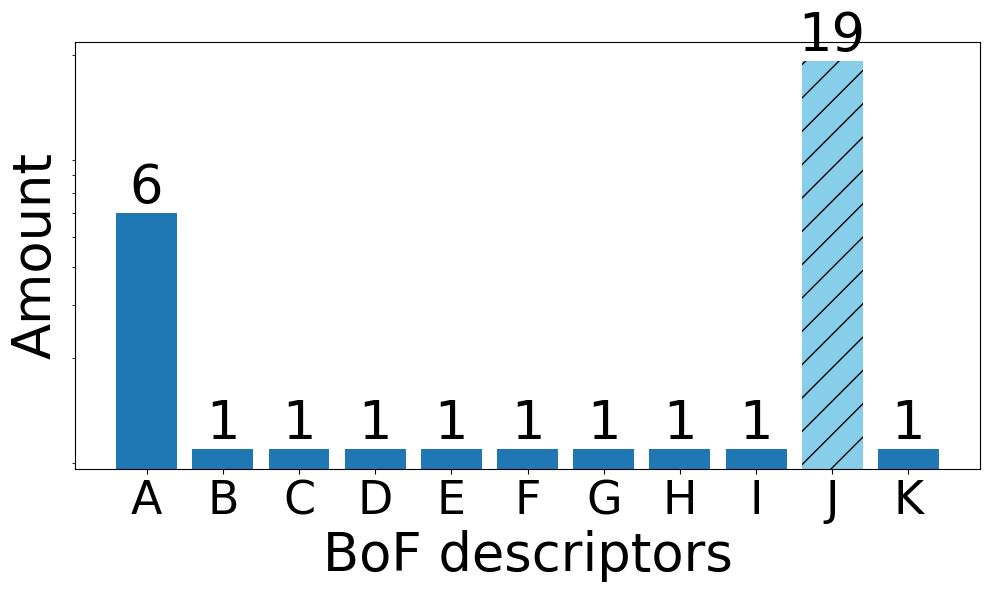

In [10]:
# Fig 7

for XX, x in [(X_raw0, 1), (X_raw1,2), (X_raw2,3)]:
    print(f'x_{x}')
    
    dfx = pd.DataFrame(XX)
    first_row = XX[0]

    # Count the unique configurations (rows) and their occurrences
    unique_configs = dfx.value_counts().sort_index()

    # Convert index to a list of configurations and reset index
    unique_configs = unique_configs.reset_index()
    unique_configs.columns = [f'Feature_{i}' for i in range(1, dfx.shape[1]+1)] + ['Count']

    # Create a label for each unique configuration using letters
    unique_configs['Config'] = list(string.ascii_uppercase[:len(unique_configs)])
    
    # Create a DataFrame for the first row
    first_row_df = pd.DataFrame([first_row], columns=unique_configs.columns[:-2])
    
    # Find the matching index
    highlight_index = unique_configs[
        unique_configs.iloc[:, :-2].apply(tuple, axis=1) == tuple(first_row)
    ].index[0]

    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(unique_configs['Config'], unique_configs['Count'])

    # Highlight the bar at the given index with stripes
    for i, bar in enumerate(bars):
        if i == highlight_index:
            # Apply hatching (stripes) to the specific bar
            bar.set_hatch('/')
            bar.set_facecolor('skyblue')  # Make the background of the bar transparent to show the hatch
            
            
    # Adding the count on top of each bar
    for bar, count in zip(bars, unique_configs['Count']):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(count), va='bottom', ha='center', fontsize=38)
    
    # Adjust this value to control the space between bars
    d = len(bars)
    x_positions = np.arange(d)
    letters = list(string.ascii_uppercase[:d]) # First d letters from A, B, C, ...
    
    plt.xlabel('BoF descriptors', fontsize=38)
    plt.ylabel('Amount', fontsize=38)
    plt.yscale('log')
    plt.yticks([])
    plt.xticks(x_positions, letters, fontsize=33)
    plt.tight_layout()
    plt.show()



# Descriptor Structure matrix

In [11]:
'''
# Convert the lists column into a numpy array with padding
df['s_matrix'] = df['s_matrix'].apply(ast.literal_eval)
df['s_matrix'] = df['s_matrix'].apply(lambda x: np.array(x))
X_raw = np.zeros((len(df), 83*83), dtype=int)
for i, row in enumerate(df['s_matrix']):
    X_raw[i,:] = row.reshape(83*83)
 
selector = VarianceThreshold(0)
X = selector.fit_transform(X_raw) 
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=100).fit_transform(X)
print(X.shape)

from matplotlib.patches import Rectangle
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')
plt.scatter(X_embedded[df['Sequence'] == optimal_seq,0], X_embedded[df['Sequence'] == optimal_seq,1],c= 'red')
plt.colorbar(label='Count')

plt.xlabel('x_1')
plt.ylabel('x_2')
plt.legend()
plt.tight_layout()
'''

"\n# Convert the lists column into a numpy array with padding\ndf['s_matrix'] = df['s_matrix'].apply(ast.literal_eval)\ndf['s_matrix'] = df['s_matrix'].apply(lambda x: np.array(x))\nX_raw = np.zeros((len(df), 83*83), dtype=int)\nfor i, row in enumerate(df['s_matrix']):\n    X_raw[i,:] = row.reshape(83*83)\n \nselector = VarianceThreshold(0)\nX = selector.fit_transform(X_raw) \nX_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=100).fit_transform(X)\nprint(X.shape)\n\nfrom matplotlib.patches import Rectangle\ncolors =np.log(df['Count'])\nplt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')\nplt.scatter(X_embedded[df['Sequence'] == optimal_seq,0], X_embedded[df['Sequence'] == optimal_seq,1],c= 'red')\nplt.colorbar(label='Count')\n\nplt.xlabel('x_1')\nplt.ylabel('x_2')\nplt.legend()\nplt.tight_layout()\n"